In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
from scipy.optimize import curve_fit
from scipy import signal
import scipy.signal as ssi

import io

In [6]:
#uploaded = files.upload()
SIZE = 50
data = pd.read_csv('sandpilesCpp/s50.txt')

Load data from a simulation run. We are mostly interested in the critical cells data, which gives the number of cells with Z = 4 grains of sand at any given time.

In [7]:
data.shape

(9999999, 2)

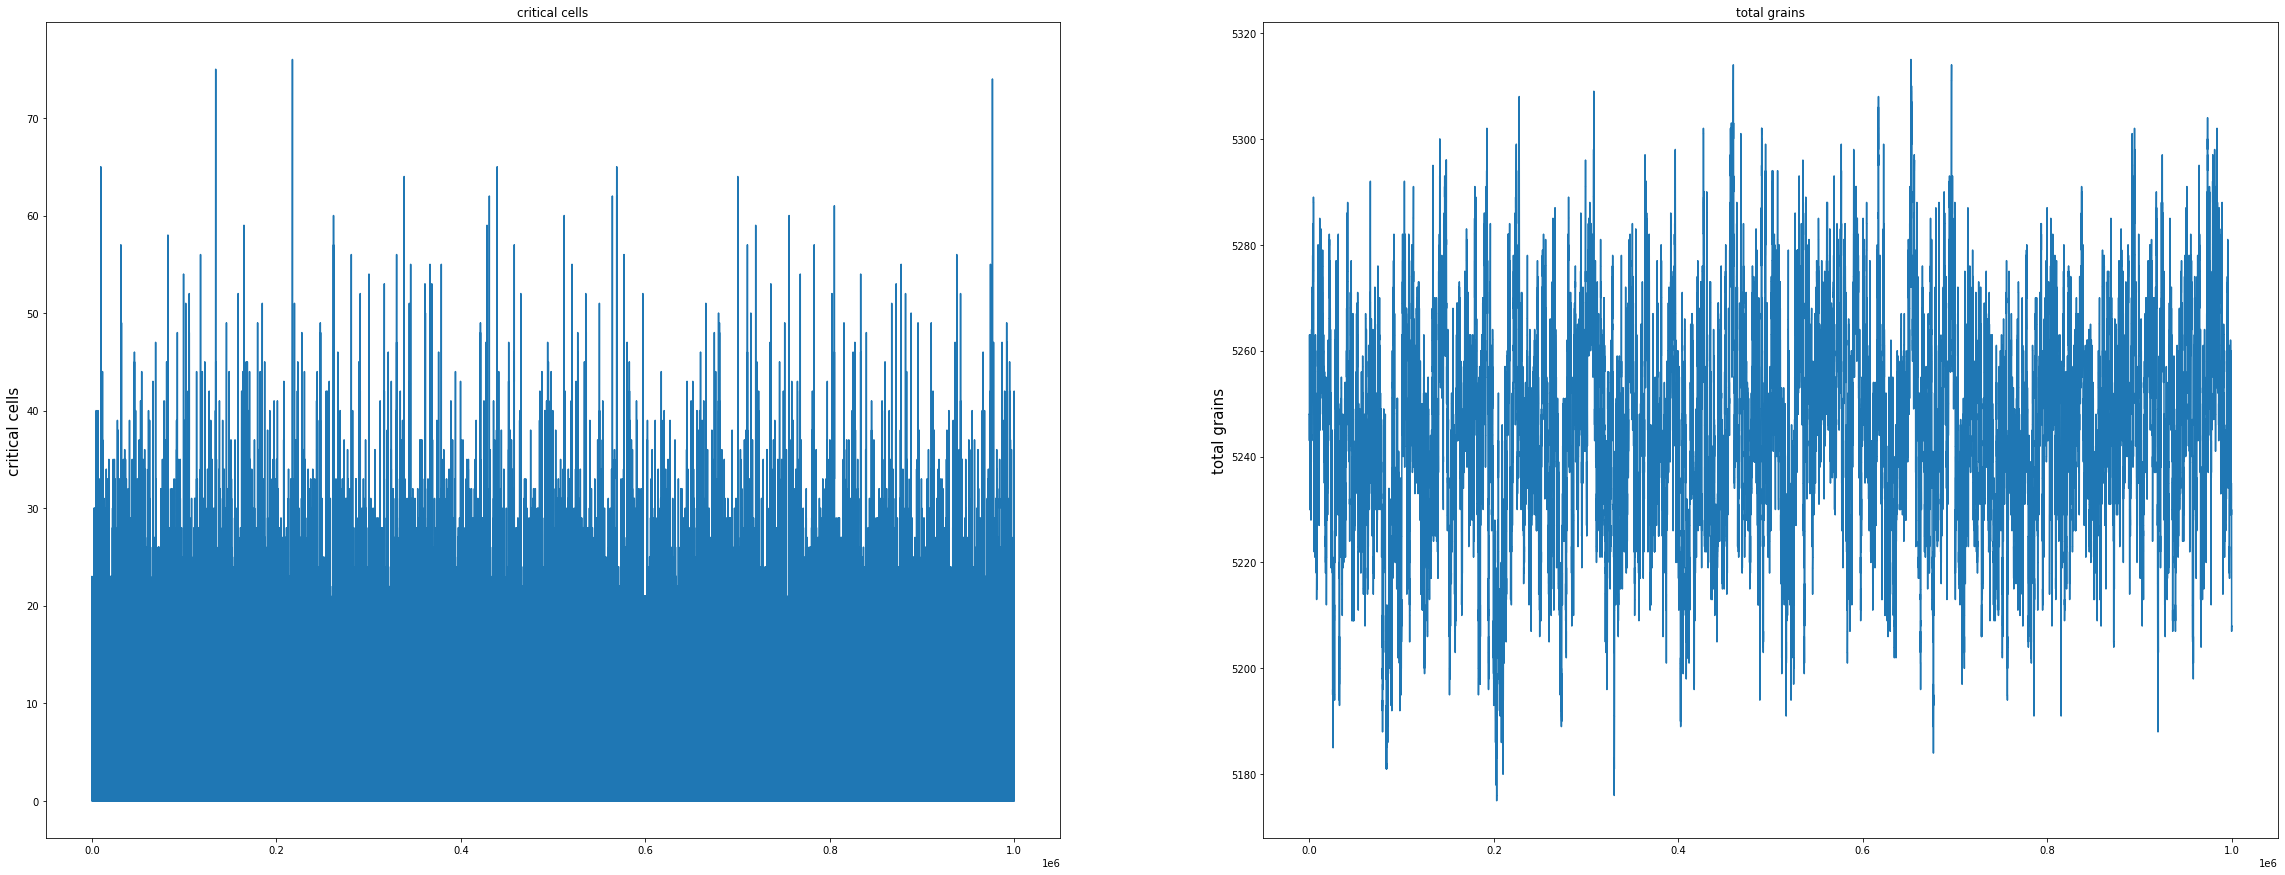

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(40,15))

def simple_plot(ax, name, y):
  ax.set_title(name)
  ax.set_ylabel(name, fontsize=15)
  ax.plot(y)
  
simple_plot(axes[0], 'critical cells', data.critical_cells[:1000000])
simple_plot(axes[1], 'total grains', data.total_grains[:1000000])

The first plot shows the number of critical cells at a given time. The fourth plot shows the total amount of grains in the map. Note that, after a transient, the total amount of grains is roughly stable at 2100-2200. We will assume that it reaches SOC at that point and drop the transient part

In [7]:
# data = data.drop(range(50000))
x = data.critical_cells.values

In [8]:
def get_avy_durations_over_treshold(x, treshold):
  durations = []
  areas = []
  quiet = []
  i = 0
  q = 0 # Duration of times under treshold
  while i < len(x):
    if x[i] > treshold:
      if q != 0:
        quiet.append(q)
        q = 0
      j = 1
      sum = x[i]
      while i+j < len(x) and x[i+j] > treshold:
        sum += x[i+j]
        j += 1
      durations.append(j)
      areas.append(sum)
      i += j
    else:
      q += 1
      i += 1
  
  return np.array(durations), np.array(areas), np.array(quiet)

def regplot(x, y, ax, cutoff = 1e10):
  ax.scatter(x, y)
  x_axes = np.linspace(min(x), max(x), num = 100)
  
  df = pd.DataFrame({'durations':x, 'areas':y})
  gb = df.groupby('durations').mean()

  perform_fit_over = gb.index < cutoff

  popt, pcov = curve_fit(lineal,
                         np.log10(gb.iloc[perform_fit_over].index.values), 
                         np.log10(gb.iloc[perform_fit_over].areas.values),
                         maxfev = 10000)
  
  ax.plot(x_axes, 10**lineal(np.log10(x_axes), *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
  ax.text(0.7, 0.7,'P(x) ~ {:f} x ^ {:f}'.format(popt[1], popt[0]), fontsize=9, transform=ax.transAxes)

  #popt, pcov = curve_fit(powerlaw, x, y, maxfev = 10000)
  #ax.plot(x_axes, powerlaw(x_axes, *popt), 'r-',
  #       label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

  ax.set_yscale('log')
  ax.set_xscale('log')
  ax.text(0.7, 0.7,'P(x) ~ {:f} x ^ {:f}'.format(popt[1], popt[0], ), fontsize=9, transform=ax.transAxes)

def powerlaw(x, a, s):
  return s * np.power(x, a)

def lineal(x, a, s):
  return a * x + s

def plot_scaling(x, ax, cutoff, weights=None, fit = 'lin'):
  x_axes = np.logspace(0, int(np.log10(max(x))) + 1, num = 2*(int(np.log10(max(x)) +2)))
  y, x_axes = np.histogram(x, bins=x_axes, density=True, weights=weights)
  x_axes = x_axes[:-1]

  ax.scatter(x_axes, y)
  ax.set_yscale('log')
  ax.set_xscale('log')

  if fit == 'lin':
    popt, pcov = curve_fit(powerlaw, x_axes[x_axes < cutoff], y[x_axes < cutoff], maxfev = 10000)
    ax.plot(x_axes, powerlaw(x_axes, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
    
    ax.text(0.7, 0.7,'P(x) ~ {:f} x ^ {:f}'.format(popt[1], popt[0]), fontsize=9, transform=ax.transAxes)
  else:
    perform_fit_over = np.logical_and(x_axes < cutoff, y>0)

    popt, pcov = curve_fit(lineal, np.log10(x_axes[perform_fit_over]), np.log10(y[perform_fit_over]), maxfev = 10000)
    ax.plot(x_axes, 10**lineal(np.log10(x_axes), *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
    ax.text(0.7, 0.7,'P(x) ~ {:f} x ^ {:f}'.format(popt[1], popt[0]), fontsize=9, transform=ax.transAxes)

  ax.set_yscale('log')
  ax.set_xscale('log')

def plot_loglog_duration_area(ax1, ax2, ax3, ax4, treshold, fit = 'lin', events = None):
  if events is None:
    durations, areas, quiets = get_avy_durations_over_treshold(x, treshold) 
  else:
    durations = np.array(events.duration.values)
    areas = np.array(events.area.values)
    quiets = np.array(events.quiet.values)

  ax1.set_title('Distribution of durations')
  plot_scaling(durations, ax1, cutoff=SIZE/2, fit=fit)
  ax2.set_title('Distribution of sizes')
  plot_scaling(areas, ax2, 5*SIZE, fit=fit)
  ax3.set_title('Distribution of quiet times')
  plot_scaling(quiets, ax3, cutoff=SIZE**2, fit=fit)

  ax4.set_title('Areas(durations)')
  regplot(durations, areas, ax4, cutoff=SIZE)

def plot_pds(x):
  fig, ax = plt.subplots(figsize=(15,15))

  f, Pxx_den = signal.welch(x, fs = SIZE, nperseg=10000)
  plt.scatter(f, Pxx_den)
  popt, pcov = curve_fit(lineal, np.log10(f[f>1]), np.log10(Pxx_den[f>1]), maxfev = 10000)
  ax.plot(f, 10**lineal(np.log10(f), *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

  ax.set_ylabel('log(S_crits)')
  ax.set_xlabel('log(f)')
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_xlim(1e-3, SIZE)
  ax.text(0.7, 0.7,'P(x) ~ {:f} x ^ {:f}'.format(popt[1], popt[0], ), fontsize=9, transform=ax.transAxes)

  return ax


First we look at the power spectra, wich is computed with the welch algorithm using a sampling frequency equal to the size of the grid. We fit it to a powerlaw for frequencies greater than 1 (equivalently, for the region of the spectrum where avalanches of duration less than the grid size contribute). The resulting spectrum scales as $S(f) \approx f ^ {-1.60}$ for SIZE = 100.

For SIZE = 50 (as in the prl paper) the scaling is $S(f) \approx f ^ {-1.67}$ (while the result of the paper is $f ^ {-1.58}$)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in log10


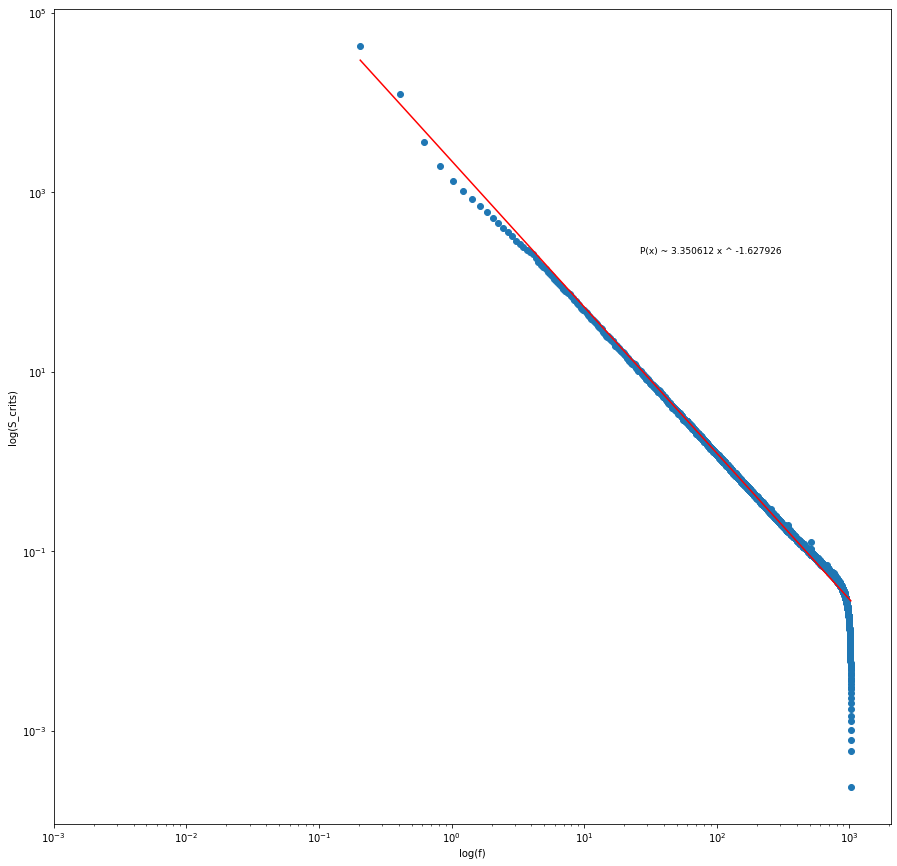

In [9]:
plot_pds(x)

We will now analyze the avalanches, defined by the duration D and the size S (S > D), the distributions are fitted to a powerlaw. The fit is performed only for durations less than the grid size / 2. The results, for size = 50 are:
1. $D(T) \approx T ^ {-0.79}$
2. $D(S) \approx S ^ {-0.98}$
3. $S(T) \approx T ^ {1.48}$
4. $D'(T) \approx T ^ {-0.45}$

Where $D'$ if the distribution weighted by the average response $S/T$, which is used in the prl paper (in the paper they swap the definitions $D$ and $D'$).

For D', the value obtained in the original paper is $T^{-0.42}$, but they seem to obtain this from the $D(S)$ distribution instead of measuring it directly.

In [ ]:
durations, areas, quiets = get_avy_durations_over_treshold(x, 0)
durations = np.array(stats.duration.values)
areas = np.array(stats.area.values)
quiet = np.array(stats.quiet.values)
durations 

array([1, 4, 5, 5])

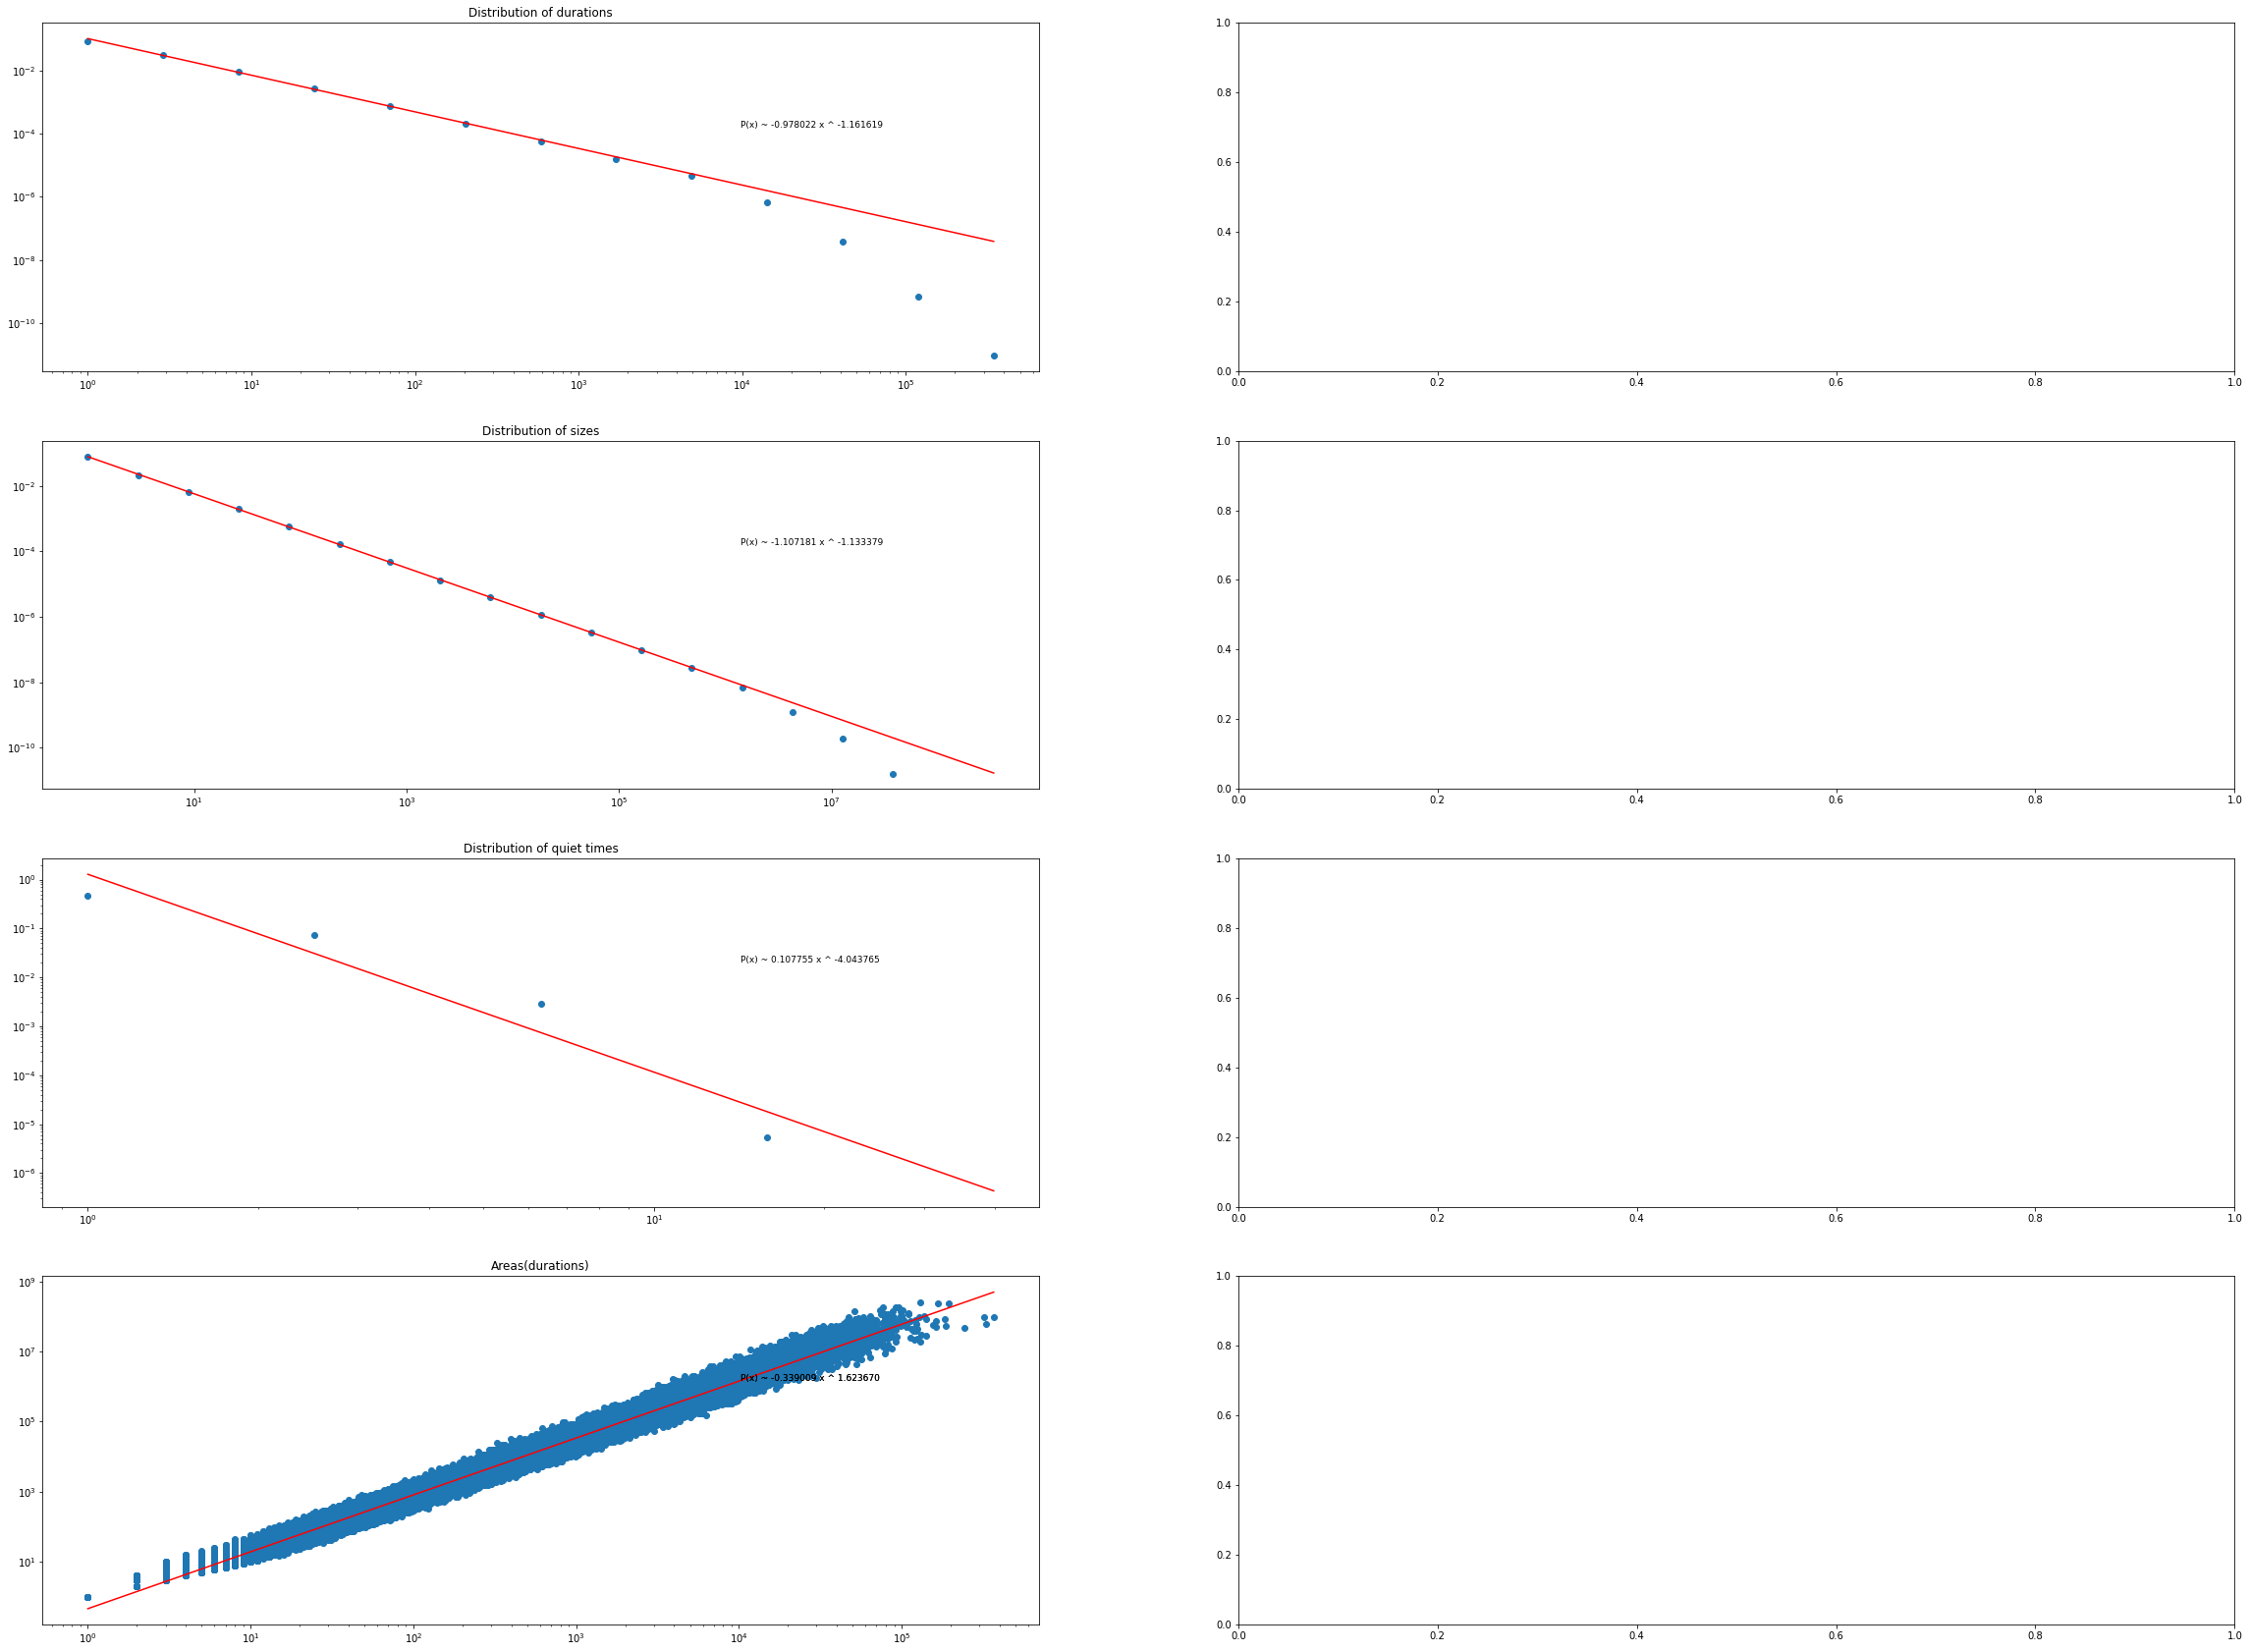

In [13]:
fig, axes = plt.subplots(4, 2, figsize=(40,30))
tresholds = [0]

for i in range(len(tresholds)):
  axes[0, i].set_title('Treshold: {}'.format(tresholds[i]))
  plot_loglog_duration_area(axes[0, i], axes[1,i], axes[2,i], axes[3,i], tresholds[i], fit='')

According to the paper, the power law distribution of lifetimes $D(T)$ leads to a power law for the PDS $S(f)$ where:

$S(f) = \int^{1/f} T D'(T) dT \approx f ^ {-2+\alpha}$ (eq 1)

Where $\alpha$ is the coeficient $D'(T) = T ^ {-\alpha}$.

I am not sure about (eq 1), in its derivation th

In [ ]:
durations, areas, quiets = get_avy_durations_over_treshold(x, 0) 
x[:200]

array([ 3,  3,  3,  3,  2,  2,  2,  4,  2,  1,  3,  4,  5,  5,  4,  3,  3,
        6,  4,  2,  4,  5,  5,  5,  3,  2,  2,  3,  3,  1,  3,  1,  2,  2,
        2,  2,  1,  1,  0,  1,  1,  2,  2,  4,  3,  6,  8, 10, 10,  7,  7,
        9,  7,  6,  5,  8, 11,  8,  6,  7,  6,  5,  3,  3,  5,  3,  5,  6,
        5,  5,  5,  6,  5,  6,  5,  6,  5,  3,  7,  7,  6,  8,  6, 10, 13,
       10, 11, 12,  8,  7,  7,  4,  3,  3,  3,  6,  8,  7,  8,  9,  6,  4,
        3,  5, 10, 13, 10,  9, 11,  8, 10, 10,  8, 10,  9, 10,  5,  3,  4,
        5,  6,  7,  6,  5,  8, 13, 11,  6,  6,  7,  8,  8,  7,  3,  1,  1,
        1,  0,  0,  1,  2,  1,  1,  2,  4,  6,  3,  4,  4,  5,  6,  3,  4,
        4,  2,  1,  0,  1,  3,  2,  3,  3,  3,  4,  4,  3,  1,  2,  4,  5,
        4,  5,  8,  4,  2,  1,  0,  1,  2,  3,  1,  1,  2,  1,  1,  2,  1,
        2,  4,  5,  5,  6,  5,  4,  4,  6,  8,  5,  3,  4])

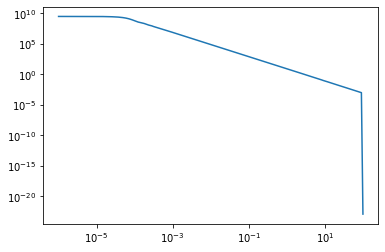

In [ ]:
omega = np.logspace(-6, 2, num = 200)
def get_pulse(T):
  lol = T[None,:]**1.47 * (np.sinc(T[None,:] * omega[:,None]) ** 2)
  #lol = T[None,:]**0.34 / (1 + ((T[None,:] * omega[:,None]) ** 2))
  return np.sum(lol, axis = 1)

T = np.arange(1, 10000)
pulse = get_pulse(T)
plt.loglog(omega, pulse)


Text(0.7, 0.7, 'P(x) ~ 8.344557 x ^ -1.988777')

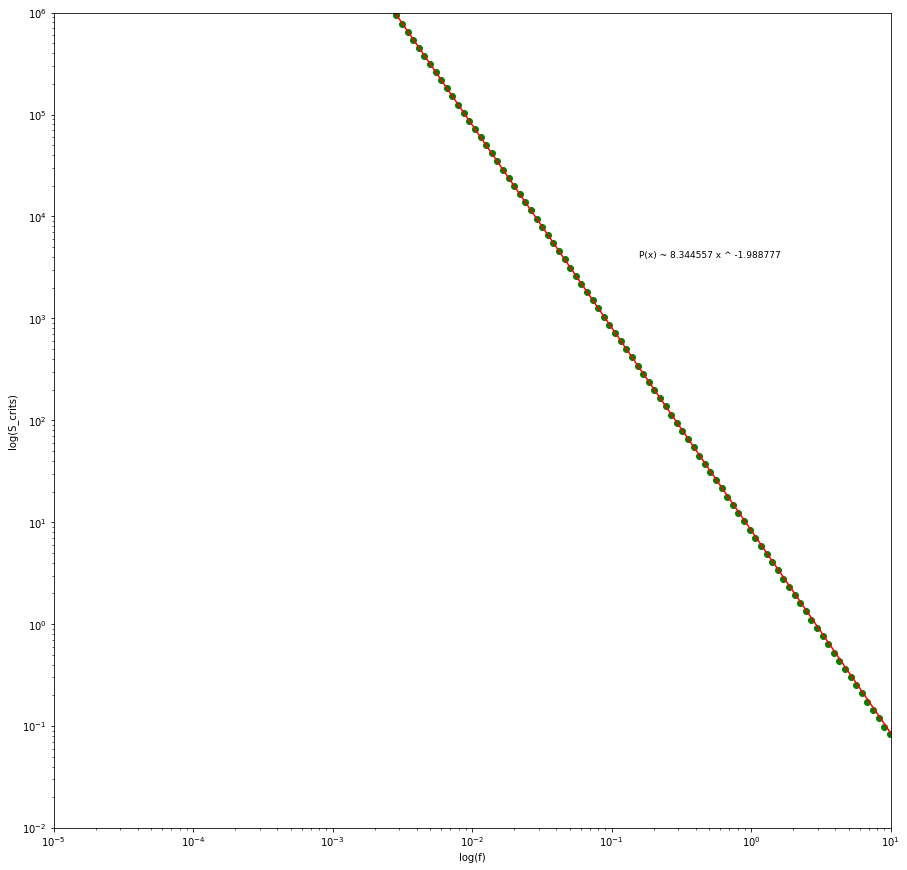

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

plt.scatter(omega, pulse, color='green')
popt, pcov = curve_fit(func, omega[omega>10**-2], pulse[omega>10**-2], maxfev = 10000)
ax.plot(omega, func(omega, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

ax.set_ylabel('log(S_crits)')
ax.set_xlabel('log(f)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(10**-2, 10**6)
ax.set_xlim(10**-5, 10)
ax.text(0.7, 0.7,'P(x) ~ {:f} x ^ {:f}'.format(popt[1], popt[0], ), fontsize=9, transform=ax.transAxes)

In [ ]:
def ladderize(x):
  result = []
  pulses = []
  durations = []
  areas = []
  i = 0
  while i < len(x):
    if x[i] > 0:
      j = 1
      sum = x[i]
      while i+j < len(x) and x[i+j] > 0:
        sum += x[i+j]
        j += 1
      result.append(sum/j * np.ones(j))
      pulses.append(x[i:i+j])
      durations.append(j)
      areas.append(sum)
      i += j
    else:
      pulses.append([0])
      result.append([0])
      i += 1
  
  return result, pulses

ladder, pulses = ladderize(x)

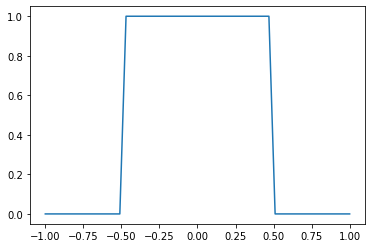

In [ ]:
times = np.linspace(-1, 1, 50)
pulse = [1 if abs(t) < 1/2 else 0 for t in times]

plt.plot(times, pulse)

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  .format(nperseg, input_length))


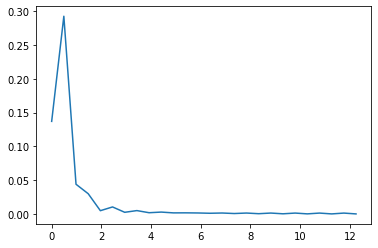

In [ ]:
from scipy import signal
f, Pxx_den = signal.welch(pulse, fs = 1/(times[1]-times[0]))
plt.plot(f, Pxx_den)

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  .format(nperseg, input_length))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in power


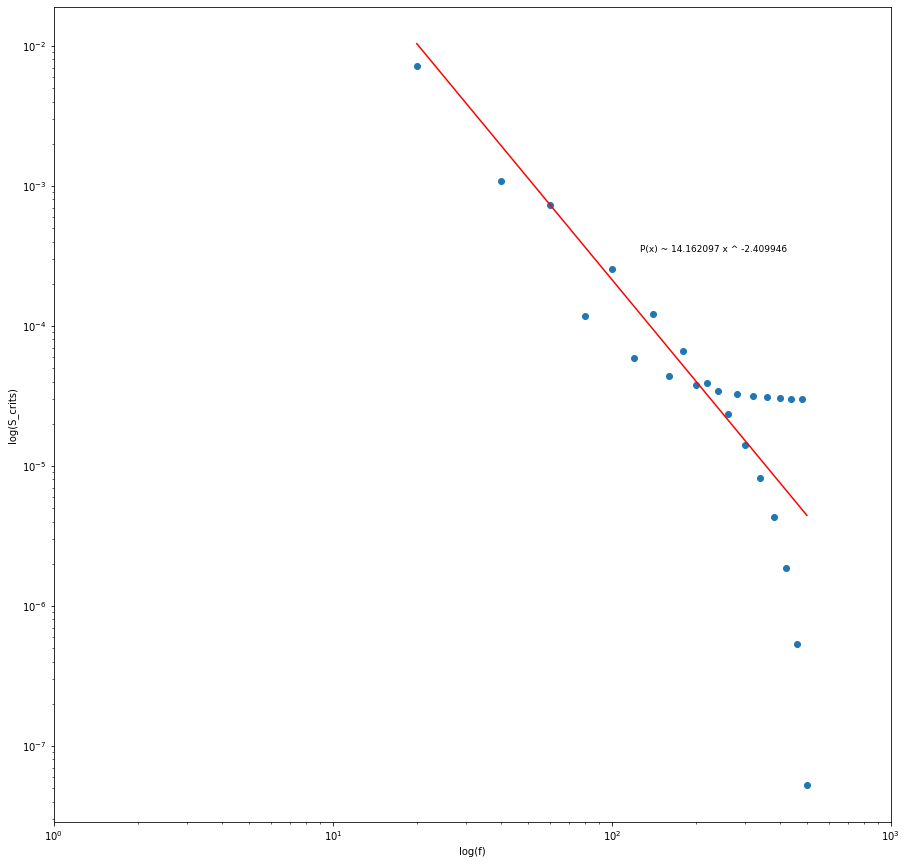

In [ ]:
plot_pds(pulse)

(1e-10, 0.5)

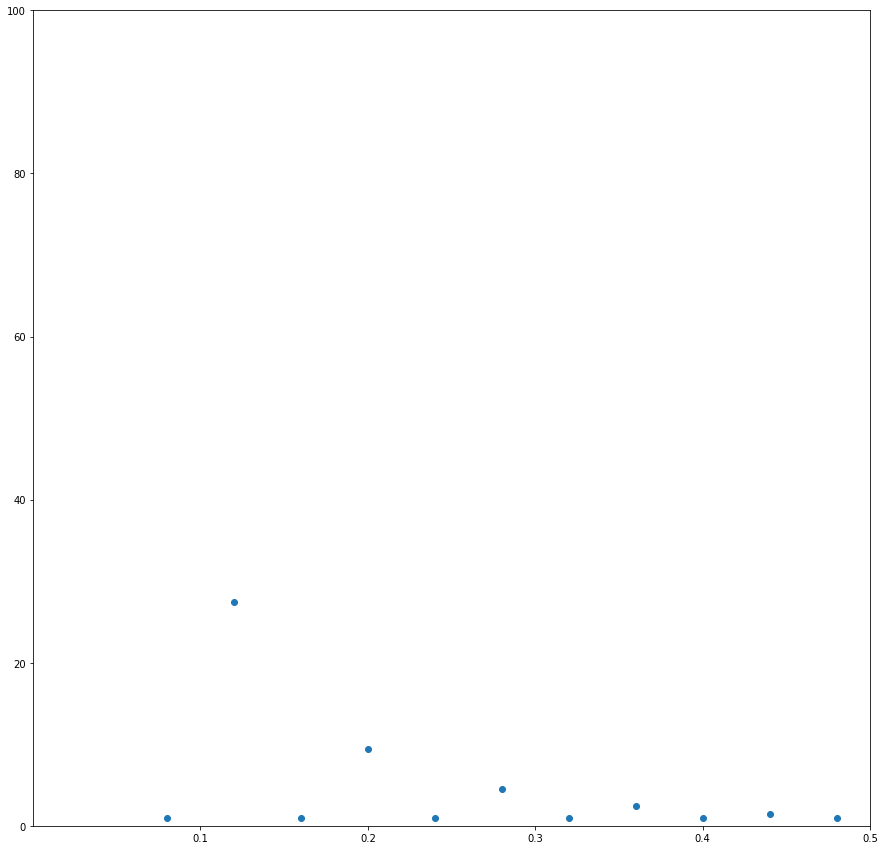

In [ ]:
from scipy.fft import fft, ifft

y = fft(pulse)
y = y[0:int(len(y)/2)]
k = np.arange(0, len(y), 1) / len(y)
fig, ax = plt.subplots(figsize=(15,15))
plt.scatter(k, np.abs(y)**2)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim(1e-10, 1e2)
ax.set_xlim(1e-10, 0.5)

In [ ]:
len(y)/2

2500.0